# Compustat World Firms Industry Classification

# 4. Final Model Fittings w/ Best Parameters and Full Data

##  Import Libraries and Load Datasets

In [15]:
# Data analysis
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import uniform, loguniform
from skopt.space import Real, Categorical, Integer
import pickle


# Preprocessing & Splitting
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.decomposition import PCA

# Modeling
from skopt import BayesSearchCV 
import xgboost
from sklearn.linear_model import LogisticRegression  
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Utils
from utils import *


In [14]:
compustat = pd.read_pickle('../data/compustat_ftreng.pkl')

In [5]:
compustat.shape

(2748178, 139)

## Model Fitting

### Preprocessing

In [64]:
year_ftrs = ['fyearq','fqtr']
num_ftrs = ['saleq', 'gpq', 'oiadpq', 'oibdpq', 'cogsq',
       'xoprq', 'atq', 'seqq', 'dlcq', 'dlttq', 'capxy', 'oancfy', 'gpm',
       'opm', 'ocfm', 'roa', 'roe', 'cd_ratio', 'ca_ratio', 'fca_ratio',
       'fce_ratio', 'fcd_ratio', 'fcs_ratio', 'tat', 'cr', 'tdr', 'der',
       'gpm_lag1', 'gpm_lag2', 'gpm_lag3', 'gpm_lag4', 'opm_lag1',
       'opm_lag2', 'opm_lag3', 'opm_lag4', 'ocfm_lag1', 'ocfm_lag2',
       'ocfm_lag3', 'ocfm_lag4', 'roa_lag1', 'roa_lag2', 'roa_lag3',
       'roa_lag4', 'roe_lag1', 'roe_lag2', 'roe_lag3', 'roe_lag4',
       'fca_ratio_lag1', 'fca_ratio_lag2', 'fca_ratio_lag3',
       'fca_ratio_lag4', 'fce_ratio_lag1', 'fce_ratio_lag2',
       'fce_ratio_lag3', 'fce_ratio_lag4', 'fcd_ratio_lag1',
       'fcd_ratio_lag2', 'fcd_ratio_lag3', 'fcd_ratio_lag4',
       'fcs_ratio_lag1', 'fcs_ratio_lag2', 'fcs_ratio_lag3',
       'fcs_ratio_lag4', 'tat_lag1', 'tat_lag2', 'tat_lag3', 'tat_lag4',
       'cr_lag1', 'cr_lag2', 'cr_lag3', 'cr_lag4', 'tdr_lag1', 'tdr_lag2',
       'tdr_lag3', 'tdr_lag4', 'der_lag1', 'der_lag2', 'der_lag3',
       'der_lag4', 'gpm_mean_4Q', 'gpm_std_4Q', 'gpm_mean_8Q',
       'gpm_std_8Q', 'opm_mean_4Q', 'opm_std_4Q', 'opm_mean_8Q',
       'opm_std_8Q', 'ocfm_mean_4Q', 'ocfm_std_4Q', 'ocfm_mean_8Q',
       'ocfm_std_8Q', 'roa_mean_4Q', 'roa_std_4Q', 'roa_mean_8Q',
       'roa_std_8Q', 'roe_mean_4Q', 'roe_std_4Q', 'roe_mean_8Q',
       'roe_std_8Q', 'fca_ratio_mean_4Q', 'fca_ratio_std_4Q',
       'fca_ratio_mean_8Q', 'fca_ratio_std_8Q', 'fce_ratio_mean_4Q',
       'fce_ratio_std_4Q', 'fce_ratio_mean_8Q', 'fce_ratio_std_8Q',
       'fcd_ratio_mean_4Q', 'fcd_ratio_std_4Q', 'fcd_ratio_mean_8Q',
       'fcd_ratio_std_8Q', 'fcs_ratio_mean_4Q', 'fcs_ratio_std_4Q',
       'fcs_ratio_mean_8Q', 'fcs_ratio_std_8Q', 'tat_mean_4Q',
       'tat_std_4Q', 'tat_mean_8Q', 'tat_std_8Q', 'cr_mean_4Q',
       'cr_std_4Q', 'cr_mean_8Q', 'cr_std_8Q', 'tdr_mean_4Q',
       'tdr_std_4Q', 'tdr_mean_8Q', 'tdr_std_8Q', 'der_mean_4Q',
       'der_std_4Q', 'der_mean_8Q', 'der_std_8Q']

#cat_ftrs = ['loc','curcdq']  # maybe not include country for now
cat_ftrs = ['curcdq'] 


In [65]:
minmax_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=True, handle_unknown='ignore'))])
preprocessor1 = ColumnTransformer(
    transformers=[
        ('minmax', minmax_transformer, year_ftrs),
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)])

numeric_transformer2 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))])
categorical_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
preprocessor2 = ColumnTransformer(
    transformers=[
        ('minmax', minmax_transformer, year_ftrs),
        ('num', numeric_transformer2, num_ftrs),
        ('cat', categorical_transformer2, cat_ftrs)])

Preprocessor suitable for XGBoost, will produce missing values

Preprocessor2 is for random forest, LR, etc. It will fill missing values with 0

### Finally Fit the Model w/ Best Parameters and Full Data (if possible)

In [69]:

def ML_Final_Fit(X_og, y_og, groups_og, preprocessor, ML_algo, sample_size=None):
    # Loop for 5 random states
    # in each loop, split, preprocess, fit, and score
    random_states = [377, 575, 610, 777, 233]

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    reports = []
    cms = []
    best_score = []
    fitted_model = []
    X_tests = []
    y_tests = []
    group_tests = []
    feature_names=[]

    for rs in range(1):
        this_rs = random_states[rs]
        
        # Split into [train,val] and test sets (80%, 20%)
        sgss = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=this_rs)
        splits = enumerate(sgss.split(X_og, y_og, groups_og))

        print('Splitting dataset into train-val and test sets (80%, 20%)')
        i, (train_val_idx, test_idx) = next(splits)
        X_train_val, X_test = X_og.iloc[train_val_idx], X_og.iloc[test_idx]
        y_train_val, y_test = y_og.iloc[train_val_idx], y_og.iloc[test_idx]
        group_train_val, group_test = groups_og.iloc[train_val_idx], groups_og.iloc[test_idx]


        #full_length = len(y_train_val)
        # After getting test set, downsample train-val 
        if sample_size is None:
            pass
        elif sample_size <= 0.3*0.8:
            print('Sampling dataset for hyperparameter tuning, sample size of train set (80%): ', sample_size*100,'%')
            flat_idx = downsample_classes(y_train_val, group_train_val, random_state=this_rs)
            flat_X, flat_y, flat_groups = X_train_val.iloc[flat_idx], y_train_val.iloc[flat_idx], group_train_val.iloc[flat_idx]
            flat_prop = len(flat_idx)/len(y_train_val)
            if int(flat_prop/sample_size)<=1: # no need to do more sampling
                X, y = flat_X, flat_y
                groups = flat_groups
            else:
                sampler = StratifiedGroupKFold(n_splits=int(flat_prop/sample_size), shuffle=True, random_state=this_rs)
                splits = enumerate(sampler.split(flat_X, flat_y, flat_groups))
                i, (_, sampled_idx) = next(splits)
                X, y = flat_X.iloc[sampled_idx], flat_y.iloc[sampled_idx]
                groups = flat_groups.iloc[sampled_idx]
        else:
            X, y, groups = X_og, y_og, groups_og

        
        X_train_val, y_train_val, group_train_val = X, y, groups
        # Split [train,val] into train and val sets (64%, 16%)
        sgss_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=this_rs)
        splits = enumerate(sgss_cv.split(X_train_val, y_train_val, group_train_val))
        '''
        for i, (train_idx, val_idx) in splits:
            X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
            y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
            group_train, group_val = group_train_val.iloc[train_idx], group_train_val.iloc[val_idx]

            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)
            X_test = preprocessor.transform(X_test)
        '''
        i, (train_idx, val_idx) = next(splits)
        X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        group_train, group_val = group_train_val.iloc[train_idx], group_train_val.iloc[val_idx]

        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
        X_test = preprocessor.transform(X_test)



        minmax_features = year_ftrs
        num_features = num_ftrs
        cat_features = preprocessor1.named_transformers_['cat']['onehot'].get_feature_names_out(cat_ftrs)

        # Combine all feature names
        all_features = minmax_features + num_features + list(cat_features)


        feature_names.append(all_features)



        print('Random State Loop: ', rs+1)
        print('Random State: ', this_rs)
        print('***Start Fitting***')
        ML_algo.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=150, verbose=True)
        
    
        # Make predictions and calculate accuracy on the test set
        y_pred = ML_algo.predict(X_test)
        y_test_voted, y_pred_voted = vote_pred(y_test, y_pred, group_test)
        
        accuracy = accuracy_score(y_test_voted, y_pred_voted)
        precision = precision_score(y_test_voted, y_pred_voted, average="weighted")
        recall = recall_score(y_test_voted, y_pred_voted, average="weighted")
        f1 = f1_score(y_test_voted, y_pred_voted, average="weighted")

        report = classification_report(y_test_voted, y_pred_voted)
        cm = confusion_matrix(y_test_voted, y_pred_voted)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        reports.append(report)
        cms.append(cm)

        fitted_model.append(ML_algo)
        X_tests.append(X_test)
        y_tests.append(y_test)
        group_tests.append(group_test)
        
    return accuracy_scores, precision_scores, recall_scores, f1_scores, cms, best_score, fitted_model, X_tests, y_tests, group_tests, feature_names

In [70]:
compustat[cat_ftrs] = compustat[cat_ftrs].astype(str)

groups = compustat['gvkey']
y = compustat['gsector_num']
X = compustat.drop(['gvkey','gsector','gsector_num','datafqtr','loc'], axis=1)

X.shape

(2748178, 134)

#### XGBoost

In [71]:
params_xgb = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'missing': np.nan,
    'device': 'cuda',
    'learning_rate': 0.1,
    'n_estimators': 250,
    'max_depth': 12,
    'colsample_bytree': 1,
    'subsample': 0.3,
    'reg_alpha': 0.5,
    'reg_lambda': 100
}

# Initialize XGBClassifier with baseline parameters
xgb_clf = xgboost.XGBClassifier(**params_xgb)
acc_xgb, pre_xgb, rec_xgb, f1_xgb, \
    cm_xgb, bs_xgb, fitted_models_xgb, \
        X_tests, y_tests, group_tests, ftr_names = ML_Final_Fit(X, y, groups, preprocessor1, xgb_clf, sample_size=1)

# Store results in a dictionary
xgb_results = {
    "accuracy": acc_xgb,
    "precision": pre_xgb,
    "recall": rec_xgb,
    "f1_score": f1_xgb,
    "conf_matrix": cm_xgb,
    "best_score": bs_xgb,
    "fitted_models": fitted_models_xgb,
    "X_tests": X_tests,
    "y_tests": y_tests,
    "group_tests": group_tests,
    "feature_names": ftr_names
}
with open('../results/xgb_results_final.pkl', 'wb') as file:
    pickle.dump(xgb_results, file)

Splitting dataset into train-val and test sets (80%, 20%)
Random State Loop:  1
Random State:  377
***Start Fitting***


/home/ubuntu/miniconda3/envs/data1030/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.32691
[1]	validation_0-mlogloss:2.26856
[2]	validation_0-mlogloss:2.21886
[3]	validation_0-mlogloss:2.17570
[4]	validation_0-mlogloss:2.13752
[5]	validation_0-mlogloss:2.10330
[6]	validation_0-mlogloss:2.07286
[7]	validation_0-mlogloss:2.04523
[8]	validation_0-mlogloss:2.01997
[9]	validation_0-mlogloss:1.99726
[10]	validation_0-mlogloss:1.97651
[11]	validation_0-mlogloss:1.95738
[12]	validation_0-mlogloss:1.93969
[13]	validation_0-mlogloss:1.92343
[14]	validation_0-mlogloss:1.90846
[15]	validation_0-mlogloss:1.89445
[16]	validation_0-mlogloss:1.88164
[17]	validation_0-mlogloss:1.86961
[18]	validation_0-mlogloss:1.85863
[19]	validation_0-mlogloss:1.84843
[20]	validation_0-mlogloss:1.83867
[21]	validation_0-mlogloss:1.82970
[22]	validation_0-mlogloss:1.82121
[23]	validation_0-mlogloss:1.81314
[24]	validation_0-mlogloss:1.80554
[25]	validation_0-mlogloss:1.79837
[26]	validation_0-mlogloss:1.79168
[27]	validation_0-mlogloss:1.78542
[28]	validation_0-mlogloss:1.7

In [73]:
xgb_results

{'accuracy': [0.47493000763553067],
 'precision': [0.5040029331430028],
 'recall': [0.47493000763553067],
 'f1_score': [0.466477494925712],
 'conf_matrix': [array([[ 290,  149,  116,   33,    5,   31,    8,   30,    5,    8,    0],
         [  18,  812,  392,  114,   21,   57,    8,   71,    5,    0,    0],
         [  39,  172, 1252,  256,   17,   88,   16,  273,   10,   22,    3],
         [  10,  157,  512,  671,   22,   79,   26,  277,   30,    1,    2],
         [   2,  115,  253,  184,   95,   69,    3,   82,    1,    1,    0],
         [   5,   79,  167,  106,    8,  621,   15,  250,    3,    0,    0],
         [   8,   21,   61,   30,    0,   25,  527,   41,    8,    5,   19],
         [   7,   89,  446,  126,    3,  152,    4, 1039,   11,    0,    0],
         [  10,   28,  127,   77,    4,   47,    4,  161,   80,    7,    0],
         [  19,   33,   74,   13,    1,    6,    4,    3,    1,  142,    1],
         [   3,   14,   31,   22,    1,    0,   11,    2,    1,    2,   69]

In [78]:
conf

array([[ 290,  149,  116,   33,    5,   31,    8,   30,    5,    8,    0],
       [  18,  812,  392,  114,   21,   57,    8,   71,    5,    0,    0],
       [  39,  172, 1252,  256,   17,   88,   16,  273,   10,   22,    3],
       [  10,  157,  512,  671,   22,   79,   26,  277,   30,    1,    2],
       [   2,  115,  253,  184,   95,   69,    3,   82,    1,    1,    0],
       [   5,   79,  167,  106,    8,  621,   15,  250,    3,    0,    0],
       [   8,   21,   61,   30,    0,   25,  527,   41,    8,    5,   19],
       [   7,   89,  446,  126,    3,  152,    4, 1039,   11,    0,    0],
       [  10,   28,  127,   77,    4,   47,    4,  161,   80,    7,    0],
       [  19,   33,   74,   13,    1,    6,    4,    3,    1,  142,    1],
       [   3,   14,   31,   22,    1,    0,   11,    2,    1,    2,   69]])

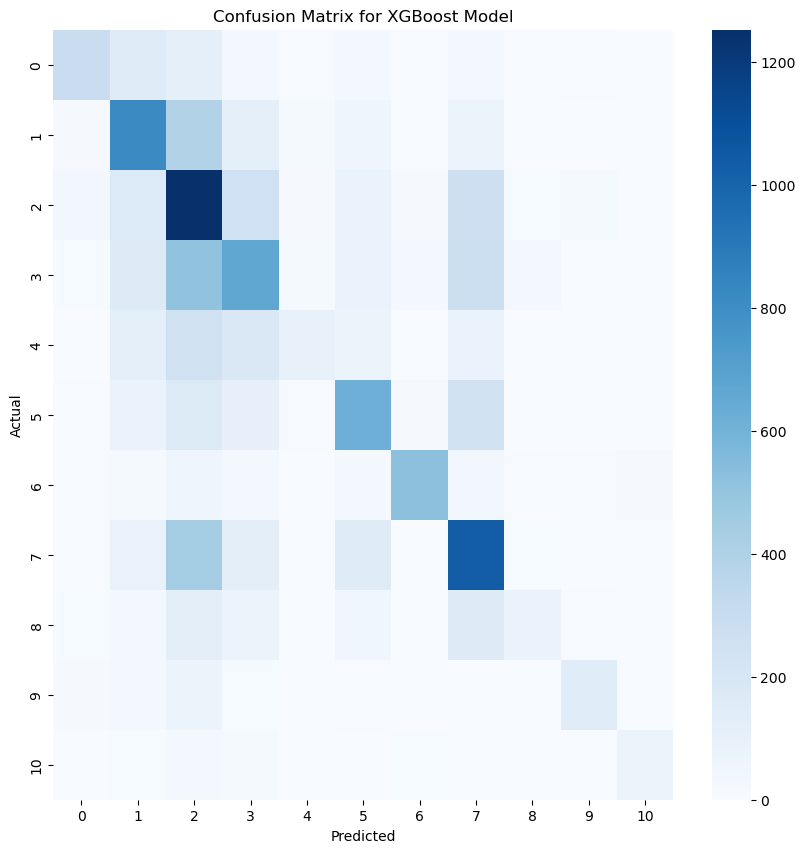

In [82]:
conf = xgb_results['conf_matrix'][0]
fig_final_conf_mat = plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=False, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost Model')
plt.savefig('../results/fig_final_conf_mat.png', bbox_inches='tight')
plt.show()

In [83]:
myxgb = xgb_results['fitted_models'][0]

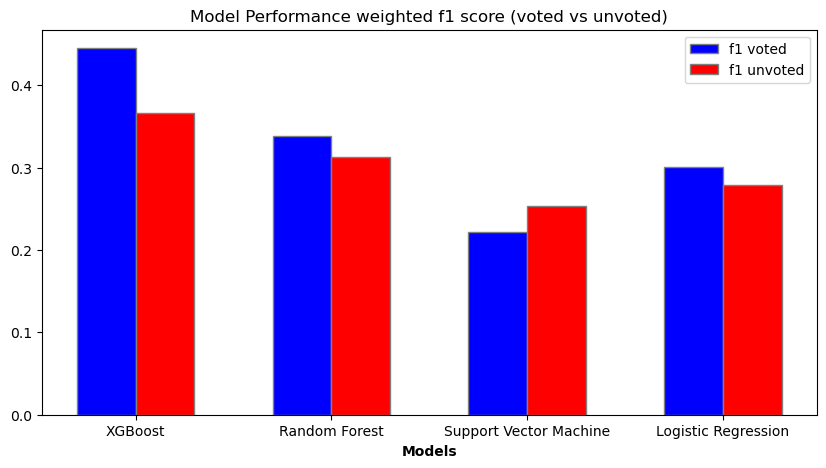

In [72]:
models = ['XGBoost', 'Random Forest', 'Support Vector Machine', 'Logistic Regression']
metric1 = [0.445227, 0.3379, 0.222, 0.3007]  # f1 voted, weighted
metric2 = [0.366723, 0.313, 0.254, 0.2789]  # f1 unvoted, weighted

barWidth = 0.3
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]

fig_mp = plt.figure(figsize=(10,5))

plt.bar(r1, metric1, color='blue', width=barWidth, edgecolor='grey', label='f1 voted')
plt.bar(r2, metric2, color='red', width=barWidth, edgecolor='grey', label='f1 unvoted')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(metric1))], models)

plt.title('Model Performance weighted f1 score (voted vs unvoted)')
plt.legend()

# Show the plot
plt.show()
fig_mp.savefig('../results/model_performance.png', dpi=300, bbox_inches='tight')


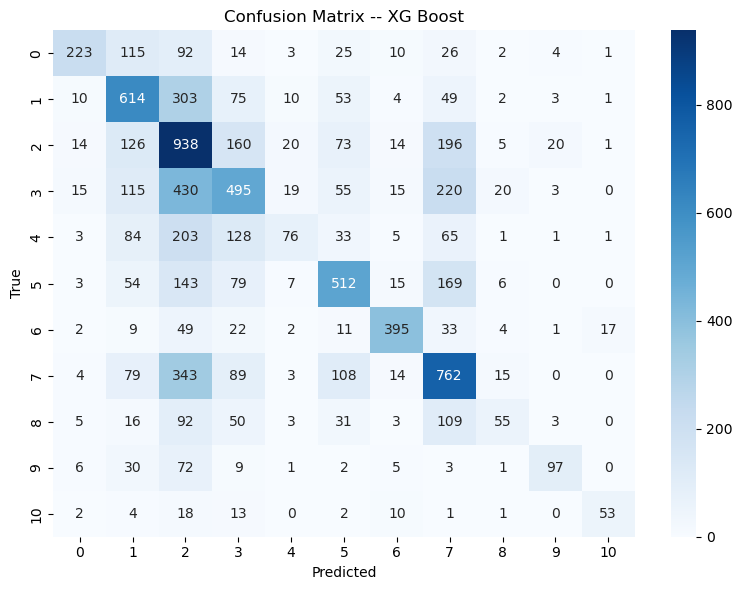

In [ ]:
cm = confusion_matrix(*vote_pred(y_test, y_test_pred, group_test))
# Plotting
fig_xgb_cm = plt.figure(figsize=(8, 6), tight_layout=True)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix -- XG Boost")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
#fig_xgb_cm.savefig('../figures/confusion_matrix_xgb.png', dpi=300)

In [ ]:
myxgb

In [84]:
xgb_results

{'accuracy': [0.47493000763553067],
 'precision': [0.5040029331430028],
 'recall': [0.47493000763553067],
 'f1_score': [0.466477494925712],
 'conf_matrix': [array([[ 290,  149,  116,   33,    5,   31,    8,   30,    5,    8,    0],
         [  18,  812,  392,  114,   21,   57,    8,   71,    5,    0,    0],
         [  39,  172, 1252,  256,   17,   88,   16,  273,   10,   22,    3],
         [  10,  157,  512,  671,   22,   79,   26,  277,   30,    1,    2],
         [   2,  115,  253,  184,   95,   69,    3,   82,    1,    1,    0],
         [   5,   79,  167,  106,    8,  621,   15,  250,    3,    0,    0],
         [   8,   21,   61,   30,    0,   25,  527,   41,    8,    5,   19],
         [   7,   89,  446,  126,    3,  152,    4, 1039,   11,    0,    0],
         [  10,   28,  127,   77,    4,   47,    4,  161,   80,    7,    0],
         [  19,   33,   74,   13,    1,    6,    4,    3,    1,  142,    1],
         [   3,   14,   31,   22,    1,    0,   11,    2,    1,    2,   69]

In [87]:
df_test = pd.DataFrame(X_tests[0], columns=ftr_names[0])

In [94]:
# your code here
import shap
shap.initjs()

explainer = shap.TreeExplainer(myxgb)
shap_values = explainer.shap_values(df_test)
# shap.summary_plot(shap_values, df_test)
global_shap_importance = np.abs(shap_values).mean(axis=0)
shap_top10_idx = np.argsort(global_shap_importance)[-10:][::-1] # top 10 features, descending order

[21:32:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.barh(ftr_names[0][shap_top10_idx], global_shap_importance[shap_top10_idx])
plt.xlabel('mean(|SHAP value|)')
plt.ylabel('Feature Name')
plt.title('Top 10 Most Important Features by SHAP')
plt.tight_layout()
plt.show()

In [ ]:
feature=pd.DataFrame({'feature':X_train.columns,'importance':XGB.feature_importances_})

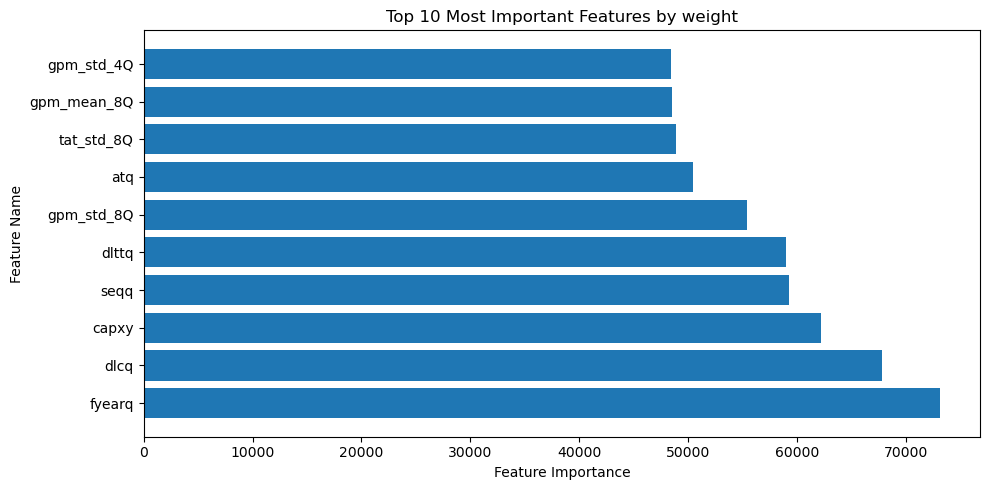

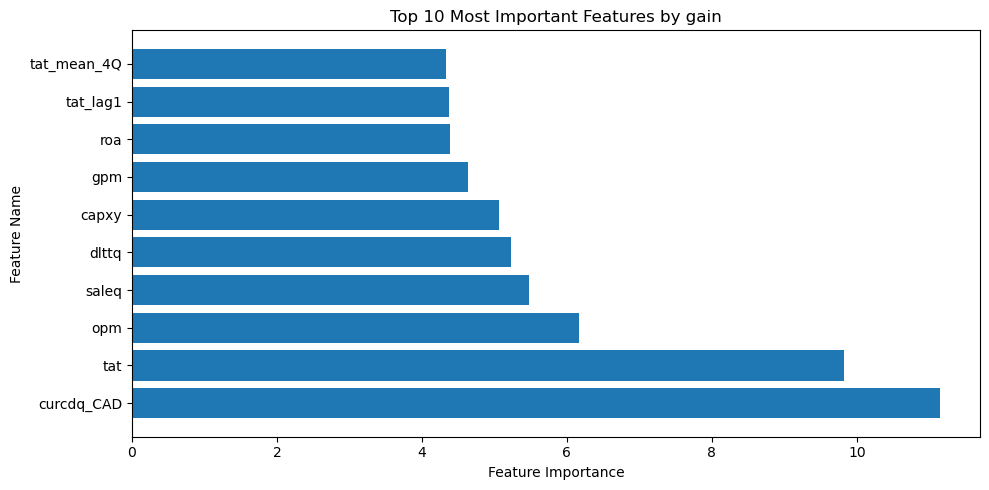

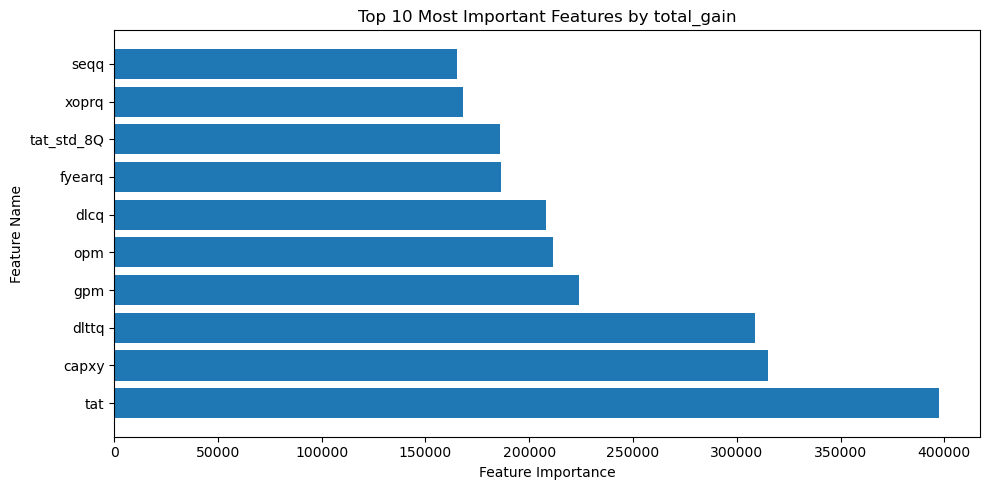

In [96]:
def xgb_top10_importance(model:xgboost.XGBRegressor, metric:str):
    importance = model.get_booster().get_score(importance_type=metric)
    ftr_name = np.array(ftr_names[0])
    ftr_importance = np.array(list(importance.values()))
    top10_idx = np.argsort(ftr_importance)[-10:][::-1] # top 10 features, descending order
    plt.figure(figsize=(10,5))
    plt.barh(ftr_name[top10_idx], ftr_importance[top10_idx])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title('Top 10 Most Important Features by '+metric)
    plt.tight_layout()
    plt.show()

xgb_top10_importance(myxgb, 'weight')
xgb_top10_importance(myxgb, 'gain')
xgb_top10_importance(myxgb, 'total_gain')
